## Reconstructing Horndeski theories via the Gaussian Process: $H(z)$ reconstruction

This is part 1 of a two-part notebook on using the Gaussian process (GP) to reconstruct Horndeski theories ([2105.12970](https://arxiv.org/abs/2105.12970)). For this notebook, we reconstruct the Hubble function $H(z)$ given the combined Pantheon/MCT, cosmic chronometers (CC), and baryon acoustic oscillations (BAO) data. The output will be directly used in part 2 on model building.

References to the data and python packages used in this work can be found at end of this notebook.

### 0. Datasets: Pantheon/MCT, CC, BAO

To start, we import the datasets (Pantheon/MCT, CC, BAO) which will be used for the reconstruction.

In [1]:
%matplotlib inline
import numpy as np
from numpy import loadtxt, savetxt
from scipy.constants import c
from matplotlib import pyplot as plt

c_kms = c/1000 # speed of light in km/s

# load pantheon + mct H(z) data
loc_sn = 'pantheon_mct.txt'
loc_sn_corr = 'pantheon_mct_corr.txt'
sn_data = loadtxt(loc_sn)
sn_corr = loadtxt(loc_sn_corr)

# setup snia observations
z_sn = sn_data[:, 0]
Ez_sn = sn_data[:, 1]
sigEz_sn_stat = sn_data[:, 2]

# construct snia cov matrix
covEz_sn_corr = np.diag(sigEz_sn_stat)@ \
                sn_corr@np.diag(sigEz_sn_stat)

# load pantheon compressed m(z) data
loc_lcparam = 'lcparam_DS17f.txt'
loc_lcparam_sys = 'sys_DS17f.txt'
lcparam = loadtxt(loc_lcparam, usecols = (1, 4, 5))
lcparam_sys = loadtxt(loc_lcparam_sys, skiprows = 1)

# setup pantheon samples
z_ps = lcparam[:, 0]
mz_ps = lcparam[:, 1]
sigmz_ps = lcparam[:, 2]

# pantheon samples systematics
covmz_ps_sys = lcparam_sys.reshape(40, 40)
covmz_ps_tot = covmz_ps_sys + np.diag(sigmz_ps**2)

# load cc dataset
loc_cc = 'cc_data.txt'
cc_data = loadtxt(loc_cc)

# setup cc observations
z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

# load bao's
loc_bao = 'bao_data.txt'
bao_data = loadtxt(loc_bao)

z_bao = bao_data[:, 0]
dmrs_bao = bao_data[:, 1] # dM/rs, rs = sound horizon
sigdmrs_bao = bao_data[:, 2]
dhrs_bao = bao_data[:, 3] # dH/rs
sigdhrs_bao = bao_data[:, 4]

The different datasets are visualized below.

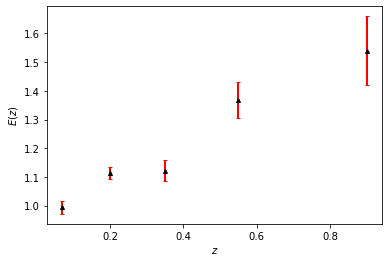

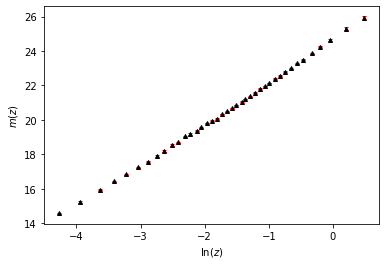

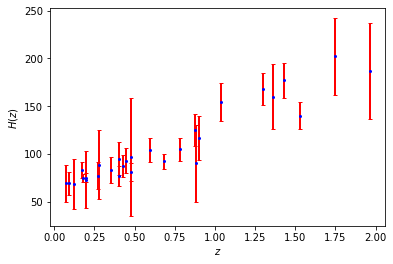

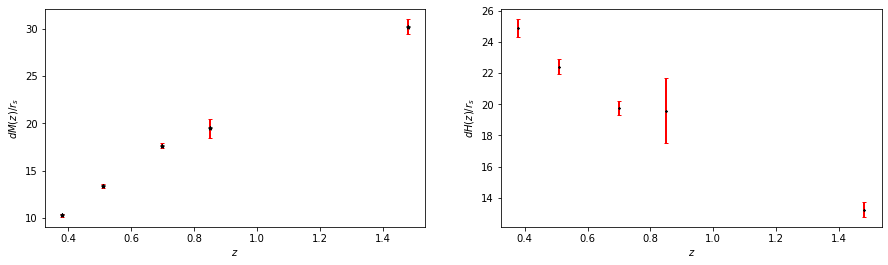

In [2]:
# pantheon/mct
plt.errorbar(z_sn, Ez_sn,
             yerr = np.sqrt(np.diag(covEz_sn_corr)),
             fmt = 'k^', markersize = 4,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$z$')
plt.ylabel('$E(z)$')
plt.show()

# pantheon samples
plt.errorbar(np.log(z_ps), mz_ps,
             yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'k^', markersize = 4,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$\ln(z)$')
plt.ylabel('$m(z)$')
plt.show()

# cosmic chronometers
plt.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
             fmt = 'bo', markersize = 2,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.show()

# bao
fig, ax = plt.subplots(1,2, figsize = (15,4))
    
ax[0].errorbar(z_bao, dmrs_bao, yerr = sigdmrs_bao,
               fmt = 'k*', markersize = 4,
               ecolor = 'red', elinewidth = 2, capsize = 2)
ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$dM(z)/r_s$')
    
ax[1].errorbar(z_bao, dhrs_bao, yerr = sigdhrs_bao,
               fmt = 'k*', markersize = 2,
               ecolor = 'red', elinewidth = 2, capsize = 2)
ax[1].set_xlabel('$z$')
ax[1].set_ylabel('$dH(z)/r_s$')
plt.show()

### 1. Reconstructing $H(z)$

In this section, we shall use the combined datasets above to reconstruct the Hubble function $H(z)$. We shall also further complement the above datasets with an $H_0$ prior. But, first, let us import the GP function and the RBF kernel.

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, ConstantKernel)

In what follows, we will use the RBF kernel, also commonly known as the squared exponential kernel.

In [4]:
kernels = {"SquaredExponential": ConstantKernel()*RBF()}

Select any one of the kernels...

In [5]:
kern_name = "SquaredExponential"
kernel = kernels[kern_name]

The $H_0$ priors we shall consider for the reconstruction are given below.

In [6]:
H0_priors = {'R19': {'ave': 74.03, 'std': 1.42},
             'TRGB': {'ave': 69.8, 'std': 1.9},
             'P18': {'ave': 67.4, 'std': 0.5}}

The Gaussian process is now performed in the next few lines. We begin with the CC dataset appended with the prior $H_0$.


Learned kernel: 117**2 * RBF(length_scale=1.35)
Log-marginal-likelihood: -127.184


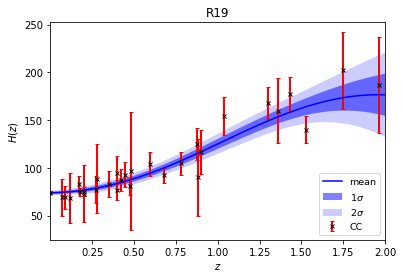


Learned kernel: 127**2 * RBF(length_scale=1.72)
Log-marginal-likelihood: -126.843


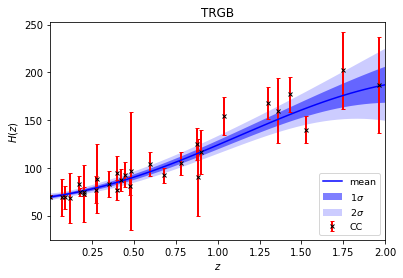


Learned kernel: 139**2 * RBF(length_scale=2.15)
Log-marginal-likelihood: -126.672


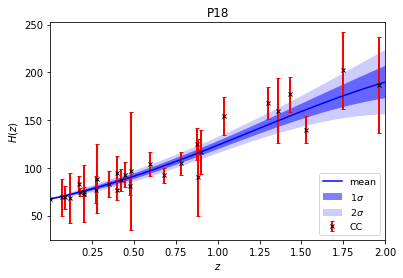

In [7]:
# set GP rec parameters
z_min = 1e-5
z_max = 2
n_div = 50
    
for H0_prior in H0_priors:

    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    
    z_cc_prior = np.append(np.array([z_min]), z_cc)
    Hz_cc_prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_prior = np.append(np.array([H0_std]), sigHz_cc)
    
    gp = GaussianProcessRegressor(kernel = kernel,
                                  alpha = sigHz_cc_prior**2,
                                  n_restarts_optimizer = 10)
    gp.fit(z_cc_prior.reshape(-1, 1), Hz_cc_prior)
    
    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    z_cc_rec = np.linspace(z_min, z_max, n_div)
    Hz_cc_rec, sigHz_cc_rec = gp.predict(z_cc_rec.reshape(-1, 1),
                                         return_std=True)

    fig = plt.figure()
    plt.errorbar(z_cc_prior, Hz_cc_prior, yerr = sigHz_cc_prior,
                 label = 'CC', fmt = 'kx', markersize = 4,
                 ecolor = 'red', elinewidth = 2, capsize = 2)
    plt.plot(z_cc_rec, Hz_cc_rec, 'b-', label = 'mean')
    plt.fill_between(z_cc_rec, Hz_cc_rec - sigHz_cc_rec,
                     Hz_cc_rec + sigHz_cc_rec,
                     alpha = .5, facecolor = 'b', edgecolor='None',
                     label= r'$1\sigma$')
    plt.fill_between(z_cc_rec, Hz_cc_rec - 2*sigHz_cc_rec,
                     Hz_cc_rec + 2*sigHz_cc_rec,
                     alpha = .2, facecolor = 'b', edgecolor='None',
                     label= r'$2\sigma$')
    plt.title(H0_prior)
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.legend(loc = 'lower right', prop = {'size': 9.5})
    plt.xlim(min(z_cc_rec),
             max(z_cc_rec))    
    plt.show()

The Pantheon/MCT dataset comes with a correlation matrix. A consistent usage of the lone Pantheon/MCT dataset therefore requires drawing many samples over the corresponding mean and covariance matrix of $E(z)$. However, regarding it as a minority in the overall dataset (CC + Pantheon/MCT + BAO dataset), we will just consider its mean for simplicity.

Moving on, the BAO $H(z)$ function can be obtained without relying on the sound horizon $r_s$ by using the Pantheon $m(z)$ samples. In particular, we take the ratio of $dM(z)/dH(z)$ and use the distance duality relation (DDR), $d_L(z) = d_A(z)(1 + z)^2$ where $d_L(z)$ and $d_A(z)$ are the luminosity distance and angular diameter distance, respectively, to obtain
\begin{equation}
H(z) = \dfrac{ dM(z) }{ dH(z) } 10^{(25 + M - m(z))/5} \ [ c / \text{Mpc} ].
\end{equation}
This requires a calibrated absolute magnitude $M$ which we determine this by sampling over the $z < 0.1$ data points in the compressed Pantheon samples. This assumes that for such very low redshifts the cosmological model-dependence should drop out and so the $\Lambda$CDM model can be taken to be a reasonably fair assumption. Furthermore, in using the DDR, we are also restricting our attention to spatially-flat and isotropic cosmologies.

The $\Lambda$CDM model is prepared below for the sampling. We import ``cobaya`` and ``getdist`` for the sampling and its statistical analysis.

In [8]:
from scipy.integrate import quad
from cobaya.run import run

def E_lcdm(a, om0):
    '''returns the rescaled Hubble function of lcdm
    
    input:
    a = scale factor
    om0 = matter density
    ol0 = dark energy density
    '''
    
    ol0 = 1 - om0
    
    return np.sqrt((om0/(a**3)) + ol0)

def E_inv_lcdm(z, om0):
    
    a = 1/(z + 1)
    
    return 1/E_lcdm(a, om0)

def dl_lcdm(z, om0):
    
    '''returns dL = luminosity distance*H0/c'''
    
    rz = quad(E_inv_lcdm, 0, z, args = (om0))[0]
    
    return (1 + z)*rz

def m_lcdm(z, H0, om0, M):
    '''returns the apparent magnitude m'''
    
    return 5*np.log10(100000*(c_kms/H0)*dl_lcdm(z, om0)) + M

# prepare the log-likelihood, consider only z < 0.1 points
nr = 29
valid = [r for r in range(covmz_ps_tot.shape[0]) if r not in 
         np.arange(len(z_ps) - nr, len(z_ps))]
covmz_ps_red = covmz_ps_tot[valid][:, valid] # covariance matrix
invcovmz_ps_red = np.linalg.inv(covmz_ps_red) # inverse C

def loglike_lcdm(H0, om0, M):
    '''returns the log-likelihood given (H0, om0, M)'''
    
    m_th = np.array([m_lcdm(z, H0, om0, M)
                     for z in z_ps[:11]])
    
    if om0 > 0:
        noise = mz_ps[:11] - m_th
        return -0.5*noise.T@invcovmz_ps_red@noise
    
    else: # rule out negative h and om0
        return -np.inf

Now, we sample over the parameter space $(H_0, \Omega_{m0}, M)$ using ``cobaya``.

*The next line will run for about five minutes*. (Optionally) skip and proceed to next line if the output has already been generated in the folder *chains*.

In [ ]:
M_calib = {}

for H0_prior in H0_priors:
    
    info_lcdm = {"likelihood": {"loglikeSNIa": loglike_lcdm}}

    info_lcdm["params"] = {"H0": {"prior": {"min": 0, "max": 100},
                                  "ref": {"min": 60, "max": 80},
                                  "proposal": 0.5,
                                  "latex": r"H_0"},
                           "om0": {"prior": {"min": -0.2, "max": 1},
                                   "ref": {"min": 0.2, "max":0.4},
                                   "proposal": 0.01,
                                   "latex": r"\Omega_{m0}"},
                           "M": {"prior": {"min": -22, "max": -16},
                                 "ref": {"min": -20, "max": -19},
                                 "proposal": 0.01,
                                 "latex": r"M"}}

    def ol0_lcdm(om0):
        '''returns the dark energy density parameter'''

        return 1 - om0    

    info_lcdm["params"]["ol0"] = {"derived": ol0_lcdm,
                                  "latex": r"\Omega_{\Lambda}"}

    def H0_prior_loglike(H0):
        '''H0_prior: assume Gaussian'''

        H0_ave = H0_priors[H0_prior]['ave']
        H0_std = H0_priors[H0_prior]['std']

        return -0.5*((H0 - H0_ave)/H0_std)**2

    info_lcdm["prior"] = {"H0_prior": H0_prior_loglike}

    info_lcdm["sampler"] = {"mcmc": {"Rminus1_stop": 0.001,
                                     "max_tries": 1000}}
    
    # save mcmc chain
    info_lcdm["output"] = 'chains/M_calib_' + H0_prior

    # overwrite chain, if it exists
    info_lcdm["force"] = True
    
    # run MCMC
    updated_info_lcdm, sampler_lcdm = run(info_lcdm)

*Note*: Since the computation only included the $z < 0.1$ data points (the first 11 of 40 points in the compressed Pantheon samples), then it is to be expected that there is much less information available about the geometry of the expansion, i.e., large confidence intervals for the $\Omega$'s. Nonetheless, the justification of this methodology is that absolute magnitude $M$ (a nuisance parameter) has been constrained to subpercent precision since this depends less on the dynamics of cosmic expansion.

The calibrated $M$ for each of the $H_0$ priors is shown below.

In [10]:
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt
import os # requires *full path*

M_calib = {}
gdsamples_per_H0_prior = {}

for H0_prior in H0_priors:
    
    folder_file = 'chains/M_calib_' + H0_prior
    gdsamples = loadMCSamples(os.path.abspath(folder_file))
    
    # get statistics
    stats = gdsamples.getMargeStats()

    M_ave = stats.parWithName("M").mean
    M_std = stats.parWithName("M").err
    
    M_calib[H0_prior] = {'ave': M_ave, 'std': M_std}
    gdsamples_per_H0_prior[H0_prior] = gdsamples
    
# print calibrated M
for each in M_calib:
    print(each, 'M = ', M_calib[each]['ave'], '+/-', M_calib[each]['std'])

[root] *WARNING* fine_bins not large enough to well sample smoothing scale - minuslogprior
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - minuslogprior__H0_prior
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__loglikeSNIa
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__loglikeSNIa
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - minuslogprior
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - minuslogprior__H0_prior
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2
[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__loglikeSNIa
R19 M =  -19.24672146997805 +/- 0.047619802661079305
TRGB M =  -19.374133105389465 +/

The posteriors for each of the $H_0$ priors are superposed in the next plot.

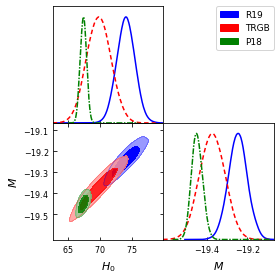

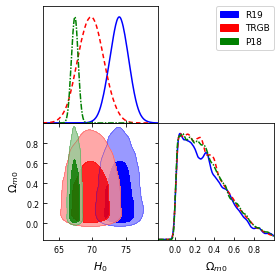

In [12]:
def plot_calib():
    '''plot posterior of cosmological parameters'''
    
    gdsamples_R16 = gdsamples_per_H0_prior['R19']
    gdsamples_TRGB = gdsamples_per_H0_prior['TRGB']
    gdsamples_P18 = gdsamples_per_H0_prior['P18']
    
    gdplot = gdplt.get_subplot_plotter()
    gdplot.triangle_plot([gdsamples_R16, gdsamples_TRGB, gdsamples_P18],
                         ["H0", "M"],
                          contour_ls = ['-', '--', '-.'],
                          contour_lws = [1.5, 1.5, 1.5],
                          contour_colors = [('blue'),
                                            ('red'),
                                            ('green')],
                          filled = True,
                          legend_loc = 'upper right',
                          legend_labels = ['R19', 'TRGB', 'P18'])
    
    gdplot = gdplt.get_subplot_plotter()
    gdplot.triangle_plot([gdsamples_R16, gdsamples_TRGB, gdsamples_P18],
                         ["H0", "om0"],
                          contour_ls = ['-', '--', '-.'],
                          contour_lws = [1.5, 1.5, 1.5],
                          contour_colors = [('blue'),
                                            ('red'),
                                            ('green')],
                          filled = True,
                          legend_loc = 'upper right',
                          legend_labels = ['R19', 'TRGB', 'P18'])
    
plot_calib()

Preparing the Hubble function given the BAO and reconstructed $m(z)$ from the Pantheon samples.

In [13]:
def H_bao(z, dMrs, dHrs, m, M):
    '''Hubble function at redshift z
    dMrs = dM(z)/rs
    dHrs = dH(z)/rs
    rs = sound horizon
    (m, M) come from dA(z) -> DDR -> dL (pantheon samples)''' 
    
    return c_kms*(dMrs/dHrs)*(1 + z)*(10**5)*(10**((M - m)/5))

def sigH_bao(z, dMrs, sigdMrs,
             dHrs, sigdHrs, m, sigm, M, sigM):
    '''uncertainty in the H_bao'''
    
    jac_dM = (10**((25 + M - m)/5))*c_kms*(1 + z)/dHrs
    jac_dH = (10**((25 + M - m)/5))*c_kms*dMrs*(1 + z)/(dHrs**2)
    jac_m = (20000*(10**((M - m)/5))*c_kms*dMrs*(1 + z)* \
             np.log(10))/dHrs
    jac_M = jac_m
    
    var_dM = (jac_dM*sigdMrs)**2
    var_dH = (jac_dH*sigdHrs)**2
    var_m = (jac_m*sigm)**2
    var_M = (jac_M*sigM)**2
            
    return np.sqrt(var_dM + var_dH + var_m + var_M)

The compressed Pantheon samples' $m(z)$ is reconstructed and plotted below.


Learned kernel: 40.3**2 * RBF(length_scale=13.2)
Log-marginal-likelihood: 60.151


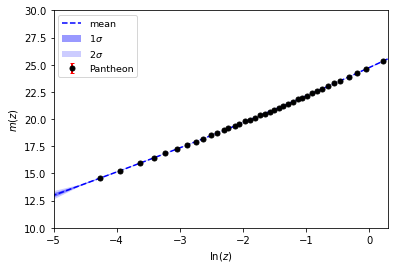

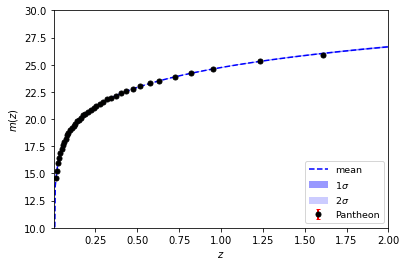

In [14]:
gp = GaussianProcessRegressor(kernel = kernel,
                              alpha = np.diag(covmz_ps_tot),
                              n_restarts_optimizer = 10)
gp.fit(np.log(z_ps).reshape(-1, 1), mz_ps)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

logz_ps_rec = np.log(np.linspace(z_min, z_max, n_div*4))
z_ps_rec = np.exp(logz_ps_rec)
mz_ps_rec, sigmz_ps_rec = \
    gp.predict(logz_ps_rec.reshape(-1, 1),
               return_std = True)
    
def mz_approx(z):
    '''approximates the reconstruction mz_rec piecewise'''
         
    delta_logz = list(abs(np.log(z) - logz_ps_rec))
    min_index = delta_logz.index(min(delta_logz))
        
    return mz_ps_rec[min_index], sigmz_ps_rec[min_index]
    
# plot in log(z)
fig = plt.figure()
plt.errorbar(np.log(z_ps), mz_ps,
             yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'ko', markersize = 5,
             ecolor = 'red', elinewidth = 2,
             capsize = 2, label = 'Pantheon')
plt.plot(logz_ps_rec, mz_ps_rec, 'b--', label = 'mean')
plt.fill_between(logz_ps_rec,
                 mz_ps_rec - sigmz_ps_rec,
                 mz_ps_rec + sigmz_ps_rec,
                 alpha = .4, facecolor = 'b',
                 edgecolor = 'None', label = r'1$\sigma$')
plt.fill_between(logz_ps_rec,
                 mz_ps_rec - 2*sigmz_ps_rec,
                 mz_ps_rec + 2*sigmz_ps_rec,
                 alpha = .2, facecolor = 'b',
                 edgecolor = 'None', label = r'2$\sigma$')
plt.xlabel('$\ln(z)$')
plt.ylabel('$m(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(np.log10(z_min), np.log10(z_max))
plt.ylim(10, 30)
plt.show()

# plot in z
fig = plt.figure()
plt.errorbar(z_ps, mz_ps,
             yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'ko', markersize = 5,
             ecolor = 'red', elinewidth = 2,
             capsize = 2, label = 'Pantheon')
plt.plot(z_ps_rec, mz_ps_rec, 'b--', label = 'mean')
plt.fill_between(z_ps_rec,
                 mz_ps_rec - sigmz_ps_rec,
                 mz_ps_rec + sigmz_ps_rec,
                 alpha = .4, facecolor = 'b',
                 edgecolor='None', label = r'1$\sigma$')
plt.fill_between(z_ps_rec,
                 mz_ps_rec - 2*sigmz_ps_rec,
                 mz_ps_rec + 2*sigmz_ps_rec,
                 alpha = .2, facecolor = 'b',
                 edgecolor='None', label = r'2$\sigma$')
plt.xlabel('$z$')
plt.ylabel('$m(z)$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.ylim(10, 30)
plt.show()

To simplify the BAO reconstructions, we setup the function below in order to obtain BAO-$H(z)$ corresponding to a given $H_0$ prior.

In [15]:
def setup_BAO(H0_prior):
    '''prepares H(z) from BAO for a given H0 prior and calibrated M'''

    M_ave = M_calib[H0_prior]['ave']
    M_std = M_calib[H0_prior]['std']
    
    # setup H(z) BAO data
    Hz_bao = []
    sigHz_bao = []

    for i in np.arange(0, len(z_bao)):

        m, sigm = mz_approx(z_bao[i])

        Hz_i = H_bao(z = z_bao[i],
                     dMrs = dmrs_bao[i],
                     dHrs = dhrs_bao[i],
                     m = m,
                     M = M_ave)

        sigHz_i = sigH_bao(z = z_bao[i],
                           dMrs = dmrs_bao[i],
                           sigdMrs = sigdmrs_bao[i],
                           dHrs = dhrs_bao[i],
                           sigdHrs = sigdhrs_bao[i],
                           m = m,
                           sigm = sigm,
                           M = M_ave,
                           sigM = M_std)

        Hz_bao.append(Hz_i)
        sigHz_bao.append(sigHz_i)

    Hz_bao = np.array(Hz_bao)
    sigHz_bao = np.array(sigHz_bao)
    
    return Hz_bao, sigHz_bao

The CC + BAO GP reconstructed-$H(z)$ is obtained in the next line. 


Learned kernel: 119**2 * RBF(length_scale=1.46)
Log-marginal-likelihood: -143.932


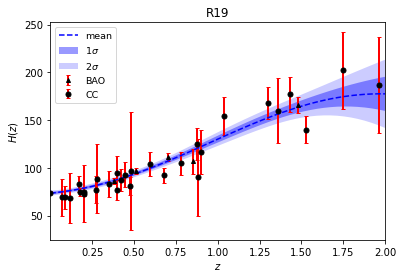


Learned kernel: 125**2 * RBF(length_scale=1.74)
Log-marginal-likelihood: -141.863


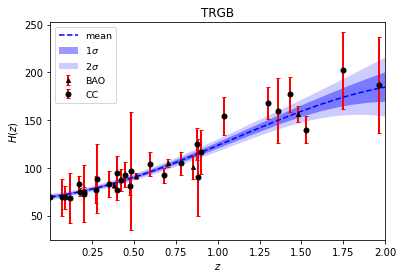


Learned kernel: 123**2 * RBF(length_scale=1.77)
Log-marginal-likelihood: -142.121


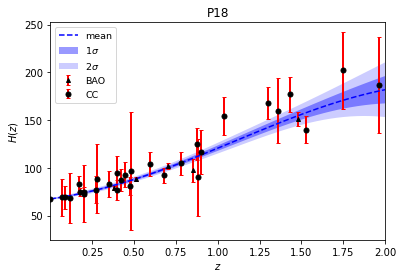

In [16]:
for H0_prior in H0_priors:
    
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    
    z_cc_prior = np.append(np.array([z_min]), z_cc)
    Hz_cc_prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_prior = np.append(np.array([H0_std]), sigHz_cc)
    
    Hz_bao, sigHz_bao = setup_BAO(H0_prior)

    z_bao_cc_prior = np.append(z_bao, z_cc_prior)
    Hz_bao_cc_prior = np.append(Hz_bao, Hz_cc_prior)
    sigHz_bao_cc_prior = np.append(sigHz_bao, sigHz_cc_prior)

    gp_bao_cc = GaussianProcessRegressor(kernel = kernel,
                                         alpha = sigHz_bao_cc_prior**2,
                                         n_restarts_optimizer = 10)
    gp_bao_cc.fit(z_bao_cc_prior.reshape(-1, 1), Hz_bao_cc_prior)
    
    print("\nLearned kernel: %s" % gp_bao_cc.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp_bao_cc.log_marginal_likelihood(gp_bao_cc.kernel_.theta))

    z_bao_cc_rec = np.linspace(z_min, z_max, n_div)
    Hz_bao_cc_rec, sigHz_bao_cc_rec = \
        gp_bao_cc.predict(z_bao_cc_rec.reshape(-1, 1),
                          return_std=True)

    fig = plt.figure()
    plt.errorbar(z_bao, Hz_bao,
                 yerr = sigHz_bao,
                 fmt = 'k^', markersize = 4,
                 ecolor = 'red', elinewidth = 2,
                 capsize = 2, label = 'BAO')
    plt.errorbar(z_cc_prior, Hz_cc_prior, yerr = sigHz_cc_prior,
                 label = 'CC', fmt = 'ko', markersize = 5,
                 ecolor = 'red', elinewidth = 2, capsize = 2)
    plt.plot(z_bao_cc_rec,
             Hz_bao_cc_rec, 'b--', label = 'mean')
    plt.fill_between(z_bao_cc_rec,
                     Hz_bao_cc_rec - sigHz_bao_cc_rec,
                     Hz_bao_cc_rec + sigHz_bao_cc_rec,
                     alpha = .4, facecolor = 'b',
                     edgecolor='None', label=r'$1\sigma$')
    plt.fill_between(z_bao_cc_rec,
                     Hz_bao_cc_rec - 2*sigHz_bao_cc_rec,
                     Hz_bao_cc_rec + 2*sigHz_bao_cc_rec,
                     alpha = .2, facecolor = 'b',
                     edgecolor='None', label=r'$2\sigma$')

    plt.title(H0_prior)
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.legend(loc = 'upper left', prop = {'size': 9.5})
    plt.xlim(z_min, z_max)

    plt.show()

The GP reconstruction given the combined CC + Pantheon/MCT + BAO is obtained in the next line. For comparison, this is shown together with the reconstructions obtained from the CC and CC + BAO datasets only.


Learned kernel: 128**2 * RBF(length_scale=1.74)
Log-marginal-likelihood: -157.870


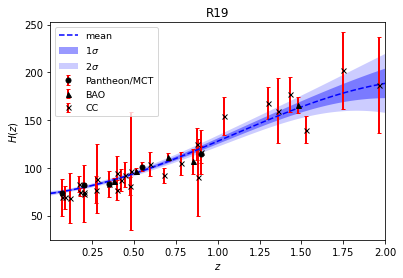

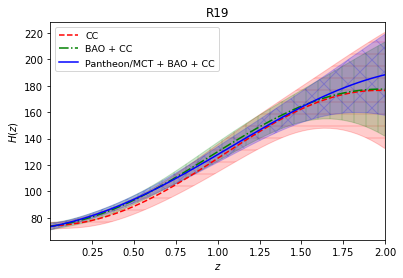


Learned kernel: 133**2 * RBF(length_scale=1.92)
Log-marginal-likelihood: -155.559


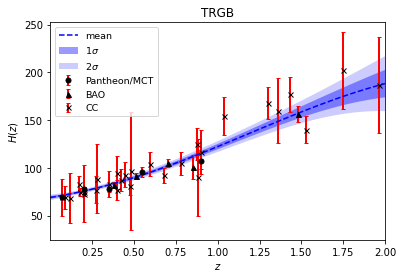

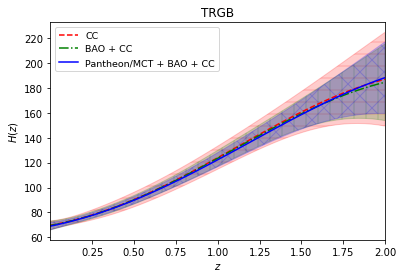


Learned kernel: 129**2 * RBF(length_scale=1.9)
Log-marginal-likelihood: -156.054


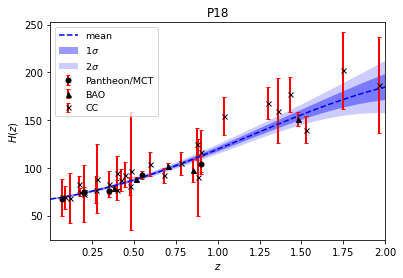

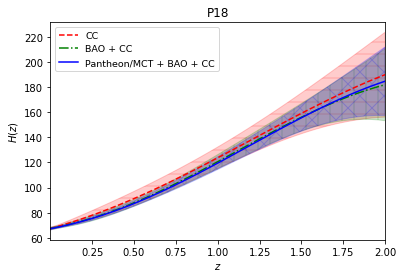

In [17]:
for H0_prior in H0_priors:
    
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    
    # reconstruct H(z): CC + prior
    z_cc_prior = np.append(np.array([z_min]), z_cc)
    Hz_cc_prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_prior = np.append(np.array([H0_std]), sigHz_cc)
    
    gp = GaussianProcessRegressor(kernel = kernel,
                                  alpha = sigHz_cc_prior**2,
                                  n_restarts_optimizer = 10)
    gp.fit(z_cc_prior.reshape(-1, 1), Hz_cc_prior)
    z_cc_rec = np.linspace(z_min, z_max, n_div)
    Hz_cc_rec, sigHz_cc_rec = gp.predict(z_cc_rec.reshape(-1, 1),
                                         return_std = True)
    
    # reconstruct H(z): CC + BAO + Prior
    Hz_bao, sigHz_bao = setup_BAO(H0_prior)
    
    z_bao_cc_prior = np.append(z_bao, z_cc_prior)
    Hz_bao_cc_prior = np.append(Hz_bao, Hz_cc_prior)
    sigHz_bao_cc_prior = np.append(sigHz_bao, sigHz_cc_prior)

    gp_bao_cc = GaussianProcessRegressor(kernel = kernel,
                                         alpha = sigHz_bao_cc_prior**2,
                                         n_restarts_optimizer = 10)
    gp_bao_cc.fit(z_bao_cc_prior.reshape(-1, 1), Hz_bao_cc_prior)

    z_bao_cc_rec = np.linspace(z_min, z_max, n_div)
    Hz_bao_cc_rec, sigHz_bao_cc_rec = \
        gp_bao_cc.predict(z_bao_cc_rec.reshape(-1, 1),
                          return_std = True)
    
    # Pantheon/MCT + CC + BAO + Prior, subscripted sbc for 'SN', 'BAO', 'CC'
    Hz_pnmct = H0_ave*Ez_sn
    var_pnmct = (np.diag(covEz_sn_corr)* \
                 (H0_ave**2)) + (H0_std*Ez_sn)**2
    
    z_sbc = np.append(z_sn, z_bao_cc_prior)
    Hz_sbc = np.append(Hz_pnmct, Hz_bao_cc_prior)
    sigHz_sbc = np.append(np.sqrt(var_pnmct), sigHz_bao_cc_prior)

    # save full data for part 2
    sbc_data = np.stack((z_sbc, Hz_sbc, sigHz_sbc), axis = 1)
    savetxt('sbc_data_' + H0_prior + '.txt', sbc_data)

    gp_sbc = GaussianProcessRegressor(kernel = kernel,
                                      alpha = sigHz_sbc**2,
                                      n_restarts_optimizer = 10)
    gp_sbc.fit(z_sbc.reshape(-1, 1), Hz_sbc)
    z_sbc_rec = np.linspace(1e-5, 2, 100)
    Hz_sbc_rec, sigHz_sbc_rec = \
        gp_sbc.predict(z_sbc_rec.reshape(-1, 1), return_std = True)

    print("\nLearned kernel: %s" % gp_sbc.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp_sbc.log_marginal_likelihood(gp_sbc.kernel_.theta))

    fig = plt.figure()

    # plot Pantheon/MCT
    plt.errorbar(z_sn, Hz_pnmct, yerr = np.sqrt(var_pnmct),
                 label = 'Pantheon/MCT', fmt = 'ko', markersize = 5,
                 ecolor = 'red', elinewidth = 2, capsize = 2)

    # plot BAO
    plt.errorbar(z_bao, Hz_bao, yerr = sigHz_bao,
                 fmt = 'k^', markersize = 5, ecolor = 'red',
                 elinewidth = 2, capsize = 2, label = 'BAO')

    # plot CC
    plt.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, label = 'CC',
                 fmt = 'kx', markersize = 5,
                 ecolor = 'red', elinewidth = 2, capsize = 2)

    # GP reconstruction from SN, BAO, CC
    plt.plot(z_sbc_rec, Hz_sbc_rec, 'b--', label = 'mean')
    plt.fill_between(z_sbc_rec,
                     Hz_sbc_rec - sigHz_sbc_rec,
                     Hz_sbc_rec + sigHz_sbc_rec,
                     alpha = .4, facecolor = 'b',
                     edgecolor = 'None', label = r'1$\sigma$')
    plt.fill_between(z_sbc_rec,
                     Hz_sbc_rec - 2*sigHz_sbc_rec,
                     Hz_sbc_rec + 2*sigHz_sbc_rec,
                     alpha = .2, facecolor = 'b',
                     edgecolor = 'None', label = '2$\sigma$')

    plt.title(H0_prior)
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.legend(loc = 'upper left', prop = {'size': 9.5})
    plt.xlim(min(z_sbc_rec), max(z_sbc_rec))
    plt.show()

    fig = plt.figure()

    # CC only
    plt.plot(z_cc_rec, Hz_cc_rec, 'r--', label = 'CC')
    plt.fill_between(z_cc_rec,
                     Hz_cc_rec - 2*sigHz_cc_rec,
                     Hz_cc_rec + 2*sigHz_cc_rec,
                     alpha = .2, facecolor = 'r',
                     edgecolor = 'r', hatch = '-')

    # CC + BAO
    plt.plot(z_bao_cc_rec, Hz_bao_cc_rec,
             'g-.', label = 'BAO + CC')
    plt.fill_between(z_bao_cc_rec,
                     Hz_bao_cc_rec - 2*sigHz_bao_cc_rec,
                     Hz_bao_cc_rec + 2*sigHz_bao_cc_rec,
                     alpha = .2, facecolor = 'g',
                     edgecolor ='g', hatch = '|')

    # CC + SN + BAO
    plt.plot(z_sbc_rec, Hz_sbc_rec, 'b-',
             label = 'Pantheon/MCT + BAO + CC')
    plt.fill_between(z_sbc_rec,
                     Hz_sbc_rec - 2*sigHz_sbc_rec,
                     Hz_sbc_rec + 2*sigHz_sbc_rec,
                     alpha = .2, facecolor = 'b',
                     edgecolor = 'b', hatch = 'x')

    plt.title(H0_prior)
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.legend(loc = 'upper left', prop = {'size': 9.5})
    plt.xlim(min(z_sbc_rec), max(z_sbc_rec))
    plt.show()

The reconstructed Hubble function will be used in part 2 to draw Horndeski theories from the Hubble data.

### References

**Data sets** used in this work:

***Pantheon/MCT***: A. G. Riess et al., Type Ia Supernova Distances at Redshift > 1.5 from the Hubble Space
Telescope Multi-cycle Treasury Programs: The Early Expansion Rate, Astrophys. J. 853 (2018)
126 [[1710.00844](https://arxiv.org/abs/1710.00844)].

***Pantheon samples***: D. M. Scolnic et al., The Complete Light-curve Sample of Spectroscopically Confirmed SNe Ia
from Pan-STARRS1 and Cosmological Constraints from the Combined Pantheon Sample,
Astrophys. J. 859 (2018) 101 [[1710.00845](https://arxiv.org/abs/1710.00845)].

***Baryon Acoustic Oscillations***, from *various sources*:

(1) BOSS collaboration, The clustering of galaxies in the completed SDSS-III Baryon Oscillation
Spectroscopic Survey: cosmological analysis of the DR12 galaxy sample, Mon. Not. Roy.
Astron. Soc. 470 (2017) 2617 [[1607.03155](https://arxiv.org/abs/1607.03155)].

(2) J. E. Bautista et al., The Completed SDSS-IV extended Baryon Oscillation Spectroscopic
Survey: measurement of the BAO and growth rate of structure of the luminous red galaxy
sample from the anisotropic correlation function between redshifts 0.6 and 1, Mon. Not. Roy.
Astron. Soc. 500 (2020) 736 [[2007.08993](https://arxiv.org/abs/2007.08993)].

(3) H. Gil-Marin et al., The Completed SDSS-IV extended Baryon Oscillation Spectroscopic
Survey: measurement of the BAO and growth rate of structure of the luminous red galaxy
sample from the anisotropic power spectrum between redshifts 0.6 and 1.0, Mon. Not. Roy.
Astron. Soc. 498 (2020) 2492 [[2007.08994](https://arxiv.org/abs/2007.08994)].

(4) A. Tamone et al., The Completed SDSS-IV extended Baryon Oscillation Spectroscopic Survey:
Growth rate of structure measurement from anisotropic clustering analysis in configuration
space between redshift 0.6 and 1.1 for the Emission Line Galaxy sample, Mon. Not. Roy.
Astron. Soc. 499 (2020) 5527 [[2007.09009](https://arxiv.org/abs/2007.09009)].

(5) A. de Mattia et al., The Completed SDSS-IV extended Baryon Oscillation Spectroscopic
Survey: measurement of the BAO and growth rate of structure of the emission line galaxy
sample from the anisotropic power spectrum between redshift 0.6 and 1.1, Mon. Not. Roy.
Astron. Soc. 501 (2021) 5616 [[2007.09008](https://arxiv.org/abs/2007.09008)].

(6) R. Neveux et al., The completed SDSS-IV extended Baryon Oscillation Spectroscopic Survey:
BAO and RSD measurements from the anisotropic power spectrum of the quasar sample
between redshift 0.8 and 2.2, Mon. Not. Roy. Astron. Soc. 499 (2020) 210 [[2007.08999](https://arxiv.org/abs/2007.08999)].

(7) J. Hou et al., The Completed SDSS-IV extended Baryon Oscillation Spectroscopic Survey:
BAO and RSD measurements from anisotropic clustering analysis of the Quasar Sample in
configuration space between redshift 0.8 and 2.2, Mon. Not. Roy. Astron. Soc. 500 (2020) 1201
[[2007.08998](https://arxiv.org/abs/2007.08998)].

(8) V. de Sainte Agathe et al., Baryon acoustic oscillations at z = 2.34 from the correlations of
Lyα absorption in eBOSS DR14, Astron. Astrophys. 629 (2019) A85 [[1904.03400](https://arxiv.org/abs/1904.03400)].

(9) M. Blomqvist et al., Baryon acoustic oscillations from the cross-correlation of Lyα absorption
and quasars in eBOSS DR14, Astron. Astrophys. 629 (2019) A86 [[1904.03430](https://arxiv.org/abs/1904.03430)].

***Cosmic Chronometers***, from *various sources*:

(1) M. Moresco, L. Pozzetti, A. Cimatti, R. Jimenez, C. Maraston, L. Verde et al., A 6%
measurement of the Hubble parameter at z ∼ 0.45: direct evidence of the epoch of cosmic
re-acceleration, JCAP 05 (2016) 014 [[1601.01701](https://arxiv.org/abs/1601.01701)].

(2) M. Moresco, Raising the bar: new constraints on the Hubble parameter with cosmic
chronometers at z ∼ 2, Mon. Not. Roy. Astron. Soc. 450 (2015) L16 [[1503.01116](https://arxiv.org/abs/1503.01116)].

(3) C. Zhang, H. Zhang, S. Yuan, S. Liu, T.-J. Zhang and Y.-C. Sun, Four new observational H(z)
data from luminous red galaxies in the Sloan Digital Sky Survey data release seven, Research in
Astronomy and Astrophysics 14 (2014) 1221 [[1207.4541](https://arxiv.org/abs/1207.4541)].

(4) D. Stern, R. Jimenez, L. Verde, M. Kamionkowski and S. A. Stanford, Cosmic chronometers:
constraining the equation of state of dark energy. I: H(z) measurements, JCAP 2010 (2010)
008 [[0907.3149](https://arxiv.org/abs/0907.3149)].

(5) M. Moresco et al., Improved constraints on the expansion rate of the Universe up to z ˜1.1 from
the spectroscopic evolution of cosmic chronometers, JCAP 2012 (2012) 006 [[1201.3609](https://arxiv.org/abs/1201.3609)].

(6) Ratsimbazafy et al. Age-dating Luminous Red Galaxies observed with the Southern African
Large Telescope, Mon. Not. Roy. Astron. Soc. 467 (2017) 3239 [[1702.00418](https://arxiv.org/abs/1702.00418)].

***R19 $H_0$ prior***: A. G. Riess, S. Casertano, W. Yuan, L. M. Macri and D. Scolnic, Large Magellanic Cloud
Cepheid Standards Provide a 1% Foundation for the Determination of the Hubble Constant and
Stronger Evidence for Physics beyond ΛCDM, Astrophys. J. 876 (2019) 85 [[1903.07603](https://arxiv.org/abs/1903.07603)].

***TRGB $H_0$ prior***: W. L. Freedman et al., The Carnegie-Chicago Hubble Program. VIII. An Independent
Determination of the Hubble Constant Based on the Tip of the Red Giant Branch, Astrophys.
J. 882 (2019) 34 [[1907.05922](https://arxiv.org/abs/1907.05922)].

***P18 $H_0$ prior***: Planck collaboration, Planck 2018 results. VI. Cosmological parameters, Astron. Astrophys. 641 (2020) A6 [[1807.06209](https://arxiv.org/abs/1807.06209)].

**Python packages** used in this work:

``scikit-learn``: F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel et al., Scikit-learn:
Machine learning in Python, [Journal of Machine Learning Research 12 (2011) 2825](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?source=post_page---------------------------).

``cobaya``: J. Torrado and A. Lewis, Cobaya: Code for Bayesian Analysis of hierarchical physical models (2020) [[2005.05290](https://arxiv.org/abs/2005.05290)].

``getdist``: A. Lewis, GetDist: a Python package for analysing Monte Carlo samples (2019) [[1910.13970](https://arxiv.org/abs/1910.13970)].

``numpy``: C. R. Harris et al., Array programming with NumPy, [Nature 585 (2020) 357–362](https://www.nature.com/articles/s41586-020-2649-2?fbclid=IwAR3qKNC7soKsJlgbF2YCeYQl90umdrcbM6hw8vnpaVvqQiaMdTeL2GZxUR0).

``scipy``: P. Virtanen et al., SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python,
[Nature Methods 17 (2020) 261](https://www.nature.com/articles/s41592-019-0686-2).

``seaborn``: M. L. Waskom, seaborn: statistical data visualization, [Journal of Open Source Software 6
(2021) 3021](https://joss.theoj.org/papers/10.21105/joss.03021).

``matplotlib``: J. D. Hunter, Matplotlib: A 2d graphics environment, [Computing in Science Engineering 9
(2007) 90](https://ieeexplore.ieee.org/document/4160265).